In [1]:
import torch 
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
import utils.config

import time 
import copy
from tqdm.notebook import trange, tqdm

import torchvision

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transformss

from models.MobileNetV3 import MobileNetV3

from models.functions import train, evaluate, confusion
#importing comet
from comet_ml import Experiment

In [2]:
#Initialising GereralTorch class

#Setting the experiment with the API key stored in config.py
experiment = Experiment(project_name = "Faces_MobileNet", workspace = "leothesouthafrican", api_key = utils.config.api_key)

#Report multiple hyperparameters using a dictionary
hyper_params = {
    'learning_rate': 0.001,
    'num_epochs': 30,
    'batch_size': 32,
    'image_size': 32,
    'image_channels': 3,
    'output_size': 10,
    'num_layers': 'na',
    'train_val_split': 0.90,
    'device': 'mps',
    'model_name': 'Basic MobileNetV3',
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'Adam',
    'dataset': 'CIFAR10',
    'best_model_path': 'MN3Small.pt',
}

#Setting the device
device = torch.device(hyper_params['device'])

# Loading model
model = MobileNetV3(mode='small')
model.to(device)

# Setting the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device) #Setting the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['learning_rate']) #Setting the optimizer

# Logging the hyperparameters to comet
experiment.log_parameters(hyper_params)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/leothesouthafrican/faces-mobilenet/c93b7dcc048d4ef3b1da4dabb1001f38



In [3]:
#defining transforms

train_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor(),
                transforms.RandomRotation(5),
                transforms.RandomHorizontalFlip(0.2),
                transforms.RandomVerticalFlip(0.2),
                transforms.RandomErasing(0.1),
                transforms.RandomCrop(hyper_params['image_size'], padding=2),
            ])

test_transform = transforms.Compose([
                transforms.Resize((hyper_params['image_size'],hyper_params['image_size'])),
                transforms.ToTensor()
            ])

In [4]:
#Loading the CIFAR10 dataset


dataset = datasets.ImageFolder(root='../faces_dataset/subjects_0', transform=train_transform)

#Splitting the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creating the dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=True,
                                            num_workers=4)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=False,
                                            num_workers=4)

# split the dataset into train and validation
train_size = int(hyper_params['train_val_split'] * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Creating the dataloaders
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=hyper_params['batch_size'],
                                            shuffle=False,
                                            num_workers=4)

print('Train data size: ', len(train_dataset))
print('Validation data size: ', len(val_dataset))
print('Test data size: ', len(test_dataset))

Train data size:  129600
Validation data size:  14400
Test data size:  28800


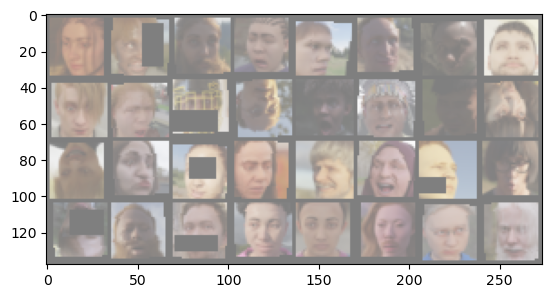

tensor(883) tensor(1229) tensor(341) tensor(1328)


In [6]:
#display random images from the dataset

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [ ]:
with experiment.train():
    train(hyper_params['num_epochs'], model, criterion, optimizer, train_loader, val_loader, hyper_params['best_model_path'], device, experiment)

Begin training...


 18%|█▊        | 652/3600 [01:37<07:02,  6.98it/s]

In [ ]:
with experiment.test():

    model.load_state_dict(torch.load(hyper_params['best_model_path']))

    test_loss, test_acc = evaluate(model, test_loader, criterion, device, experiment)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

100%|██████████| 313/313 [00:06<00:00, 49.67it/s]

Test Loss: 0.936 | Test Acc: 67.53%


In [ ]:
confusion(model, test_loader, device = device, experiment=experiment)

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/mobilenet/bc92d88d1297442bb7fa2dfbd5b2b3a8
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_acc [313]      : (0.27955271565495204, 67.53194888178913)
COMET INFO:     test_loss [313]     : (0.001735667070260825, 0.9361007741084114)
COMET INFO:     train_acc [46890]   : (0.0, 0.96875)
COMET INFO:     train_loss [46890]  : (0.2313055396080017, 3.6640939712524414)
COMET INFO:     train_val_acc [30]  : (0.4596, 0.7636)
COMET INFO:     train_val_loss [30] : (0.6687131062814384, 1.5075855710703856)
COMET INFO:   Parameters:
COMET INFO:     batch_size                             : 32
COMET INFO:     best_model_path                        : MN3Small.pt
COMET INFO:     criterion                              : CrossEntropyLo

In [ ]:
!touch requirements.txt